# Import thư viện

In [1]:
import numpy as np
import os
import cv2

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, Bidirectional, Dense, Input, Concatenate, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

from convGRU import ConvGRU
import tensorflow_addons as tfa
from Yogi_torch import Yogi
import h5py

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you 

# Dữ liệu đầu vào

### Đọc dữ liệu ảnh

In [2]:
# Đường dẫn đến thư mục chứa ảnh
image_folder = r"C:\Users\Administrator\Desktop\Fair_2024_BacSon_ConvLSTM_Bi-ConvLSTM_ConvGRU-main\data"
# image_folder = r"E:\BacSon\Fair_2023_ARIMA_LSTM_GRU\dataSet\data_img"

# Đọc từng file ảnh
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

In [3]:
# Chuyển ảnh về ma trận ảnh Gray

def matrix_images(image_folder, image_files):
    matrix_img = []
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        matrix_img.append(image)

    return matrix_img

### Chuẩn hóa dữ liệu

In [4]:
# Áp dụng Min-Max Scaling chuẩn hóa dữ liệu
def min_max_scaling(data):
    # Chuyển danh sách các mảng numpy thành một mảng numpy đa chiều
    data_array = np.array(data)

    # Tính giá trị min và max trên toàn bộ dữ liệu
    data_min = np.min(data_array)
    data_max = np.max(data_array)

    # Áp dụng công thức Min-Max Scaling
    scaled_data = (data_array - data_min) / (data_max - data_min)

    return scaled_data

### Tạo nhãn cho dữ liệu

In [5]:
# Tạo nhãn chuỗi dữ liệu với 4 ảnh liên tiếp từ dữ liệu hình ảnh
def create_image_sequences(data, time_steps):
    num_samples, height, width, channels = data.shape
    num_frames = num_samples - time_steps
    input_sequences = np.zeros((num_frames, time_steps, height, width, channels))
    labels = np.zeros((num_frames, height, width, channels))  # Khởi tạo mảng label

    for i in range(num_frames):
        input_sequences[i] = data[i:i+time_steps]
        labels[i] = data[i+time_steps]  # Xác định label là frame tiếp theo

    return input_sequences, labels

### Chia dữ liệu

In [6]:
# Chia dữ liệu
def Split_Data(X_data, y_data):
    size = int(len(X_data) * 0.8)
    size_val = int((len(X_data) - size) / 2)

    X_train = X_data[:size]
    X_val = X_data[size:size + size_val]
    X_test = X_data[-size_val:]

    y_train = y_data[:size]
    y_val = y_data[size:size + size_val]
    y_test = y_data[- size_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Mô hình ConvGRU

In [7]:
def conv_gru(X_train):
    # Các tham số đầu vào
    input_size = (X_train.shape[-2:])
    channels = X_train.shape[2]
    num_layers = 3
    hidden_dim = [16, 128, 1]
    kernel_size = [(5, 5), (3, 3), (5, 5)]
    activation = torch.nn.ReLU

    # Xây dựng mô hình
    model_GRU = ConvGRU(input_size=input_size, input_dim=channels,
                        hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers,
                        dtype=torch.FloatTensor,
                        batch_first=True,
                        bias=True,
                        return_all_layers=False,
                        activation=activation)
    
    return model_GRU

# Đánh giá và Test mô hình

### Dự đoán 

In [8]:
# Đánh giá kết quả dự báo
def evaluate(y_test, predicted_images):
    y_test = np.array(y_test)
    # Đánh giá MSE MAE R^2
    mse = mean_squared_error(y_test.flatten(), predicted_images.flatten())
    print("Mean Squared Error (MSE):", mse)
    mae = mean_absolute_error(y_test.flatten(), predicted_images.flatten())
    print("Mean Absolute Error (MAE):", mae)
    r2 = r2_score(y_test.flatten(), predicted_images.flatten())
    print("R-squared (R2) Score:", r2)

In [9]:
# Vẽ các ảnh dự đoán
def plots(predicted_images):
    # Hiển thị các ảnh dự đoán
    fig, axs = plt.subplots(1, len(predicted_images), figsize=(15, 25))
    for i in range(len(predicted_images)):
        axs[i].imshow(predicted_images[i])  # Hiển thị ảnh cuối cùng trong mỗi mẫu dự đoán
        axs[i].set_title(f"Ảnh dự đoán {i+1}")
    plt.show()

In [10]:
def test_model(model, X_test):
    # Dự đoán ảnh mới
    predicted = model.predict(X_test)
    predicted_images = np.array(predicted)

    return predicted_images

In [11]:
def test_model_BiConvLSTM(model, X_test):
    # Dự đoán ảnh mới
    predicted = model.predict(X_test)
    predicted_images = np.mean(predicted, axis=-1, keepdims=True)  # Tính trung bình hai kênh màu

    return predicted_images

In [12]:
def load_model_from_hdf5(file_path, model):
    with h5py.File(file_path, 'r') as f:
        for name, param in model.named_parameters():
            if name in f:
                param_data = torch.tensor(f[name][:])
                param.data.copy_(param_data)
            else:
                print(f"Không tìm thấy {name} trong file HDF5.")
    return model

def test_model_ConvGRU(X_train_gru, best_model_path, test_dataloader):
    model_eval = conv_gru(X_train_gru)
    model_eval = load_model_from_hdf5(best_model_path, model_eval)
    model_eval.eval()

    predictions = []
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            outputs, _ = model_eval(X_batch)
            output_last_image = outputs[-1][:, -1, ...]
            predictions.append(output_last_image.cpu().numpy())

    predicted_images = np.concatenate(predictions)
    predicted_images = np.squeeze(predicted_images)

    predicted_images = np.expand_dims(predicted_images, axis=-1)

    return predicted_images

# Chạy các mô hình

### Chuẩn bị đầu vào

In [13]:
# Đọc dữ liệu ảnh
data_img = matrix_images(image_folder, image_files)

# Chuẩn hóa dữ liệu
data_scaler = min_max_scaling(data_img)
data_lstm = np.expand_dims(data_scaler, axis=-1)

# Tạo chuỗi dữ liệu với 4 ảnh liên tiếp từ dữ liệu hình ảnh
epochs = 3
time_step = 4
X_data, y_data = create_image_sequences(data_lstm, time_step)

# Chia dữ liệu
X_train, y_train, X_val, y_val, X_test, y_test = Split_Data(X_data, y_data)

# Kiểm tra kích thước của X_train
print("Kích thước của X_train:", X_train.shape)
print("Kích thước của X_val:", X_val.shape)
print("Kích thước của X_test:", X_test.shape)

print("Kích thước của y_train:", y_train.shape)
print("Kích thước của y_val:", y_val.shape)
print("Kích thước của y_test:", y_test.shape)

Kích thước của X_train: (48, 4, 150, 150, 1)
Kích thước của X_val: (6, 4, 150, 150, 1)
Kích thước của X_test: (6, 4, 150, 150, 1)
Kích thước của y_train: (48, 150, 150, 1)
Kích thước của y_val: (6, 150, 150, 1)
Kích thước của y_test: (6, 150, 150, 1)


In [14]:
# Tạo chuỗi dữ liệu với 4 ảnh liên tiếp từ dữ liệu hình ảnh
data_gru = np.expand_dims(data_scaler, axis=1)
X_data_gru, y_data_gru = create_image_sequences(data_gru, time_step)

# Chia dữ liệu
X_train_gru, y_train_gru, X_val_gru, y_val_gru, X_test_gru, y_test_gru = Split_Data(X_data_gru, y_data_gru)

# Kiểm tra kích thước của X_train
print("Kích thước của X_train:", X_train_gru.shape)
print("Kích thước của X_val:", X_val_gru.shape)
print("Kích thước của X_test:", X_test_gru.shape)

print("Kích thước của y_train:", y_train_gru.shape)
print("Kích thước của y_val:", y_val_gru.shape)
print("Kích thước của y_test:", y_test_gru.shape)

# Chuyển đổi các mảng thành các tensor
X_train_tensor = torch.tensor(X_train_gru, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_gru, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_gru, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_gru, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_gru, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_gru, dtype=torch.float32)

# Tạo DataLoader cho training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

Kích thước của X_train: (48, 4, 1, 150, 150)
Kích thước của X_val: (6, 4, 1, 150, 150)
Kích thước của X_test: (6, 4, 1, 150, 150)
Kích thước của y_train: (48, 1, 150, 150)
Kích thước của y_val: (6, 1, 150, 150)
Kích thước của y_test: (6, 1, 150, 150)


### Mô hình ConvLSTM

In [15]:
# Load the model
best_model_ConvLTSM = keras.models.load_model('./KetQua/ConvLSTM/best_model_ConvLSTM_Adam.hdf5')

# Dự đoán trên model tốt nhất
predicted_images_ConvLTSM = test_model(best_model_ConvLTSM, X_test)


1/1 [==============================] - 3s 3s/step


Mean Squared Error (MSE): 0.007879720486641147
Mean Absolute Error (MAE): 0.040854879278423906
R-squared (R2) Score: 0.7356319005271752


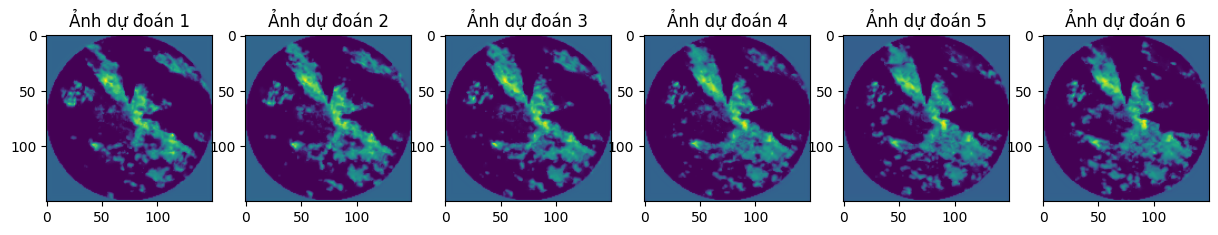

In [16]:
# Đánh giá mô hình
evaluate(y_test, predicted_images_ConvLTSM)

# Vẽ các ảnh dự đoán
plots(predicted_images_ConvLTSM)

### Mô hình Bi-ConvLSTM

In [17]:
# Load the model
best_model_BiConvLTSM = keras.models.load_model('./KetQua/BiConvLSTM/BiConvLSTM_Adam.hdf5')

# Dự đoán trên model tốt nhất
predicted_images_BiConvLTSM = test_model_BiConvLSTM(best_model_BiConvLTSM, X_test)

1/1 [==============================] - 17s 17s/step


Mean Squared Error (MSE): 0.007641355785333971
Mean Absolute Error (MAE): 0.04289921022817158
R-squared (R2) Score: 0.7436291414410907


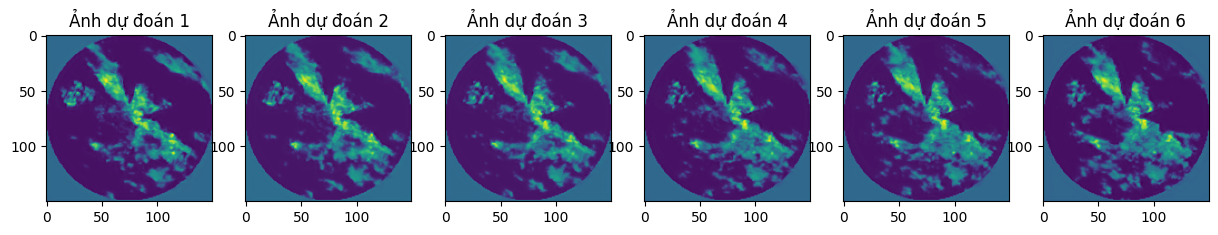

In [18]:
# Đánh giá mô hình
evaluate(y_test, predicted_images_BiConvLTSM)

# Vẽ các ảnh dự đoán
plots(predicted_images_BiConvLTSM)

### Mô hình GRU

In [19]:
# Xác định mô hình tốt nhất
best_model_path_ConvGRU = './KetQua/ConvGRU/best_model_ConvGRU_Adam.hdf5'

# Dự đoán trên model tốt nhất
predicted_images_ConvGRU = test_model_ConvGRU(X_train_gru, best_model_path_ConvGRU, test_dataloader)

Mean Squared Error (MSE): 0.007869602408396363
Mean Absolute Error (MAE): 0.04284509838451794
R-squared (R2) Score: 0.7359713665171713


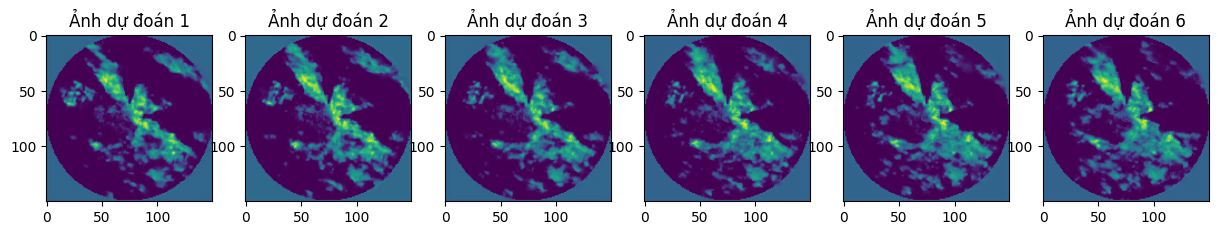

In [20]:
# Đánh giá mô hình
evaluate(y_test_gru, predicted_images_ConvGRU)

# Vẽ các ảnh dự đoán
plots(predicted_images_ConvGRU)

# Kết hợp các mô hình

In [21]:
import tensorflow as tf
import random
from sklearn.linear_model import LinearRegression, LogisticRegression

### Sử dụng Fully Connection

In [22]:
# Tạo dãy số học cho seeds
def arithmetic_sequence(start, step, count):
    return [start + step * i for i in range(count)]

def model_FC(seed, predictions_list):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    # Tạo danh sách các input layers
    inputs = [Input(shape=pred.shape[1:]) for pred in predictions_list]
    
    # Kết hợp đầu ra dự đoán bằng cách concat
    combined_output = Concatenate()(inputs)
    combined_output = Dense(units=32, activation='relu')(combined_output)
    combined_output = Dense(units=1, activation='linear')(combined_output)
    combined_model = Model(inputs=inputs, outputs=combined_output)

    # Dự đoán sử dụng mô hình kết hợp
    predictions = combined_model.predict(predictions_list)

    return predictions

def train_model_FC(y_val, *predicted_images_list):
    # Thử nghiệm với mỗi seed và đánh giá hiệu suất
    best_seed = None
    best_score = float('inf')
    for seed in arithmetic_sequence(start=0, step=10, count=500):
        combined_prediction = model_FC(seed, *predicted_images_list)
        score = mean_absolute_error(y_val.flatten(), combined_prediction.flatten())
        print(f"Seed: {seed}, Score: {score}")
        if score < best_score:
            best_score = score
            best_seed = seed
    # combined_prediction = model_FC(best_seed, *predicted_images_list)
    return best_seed

In [23]:
# Du doan tren tap val
val_pred_BiConvLTSM = test_model_BiConvLSTM(best_model_BiConvLTSM, X_val)
val_pred_ConvLTSM = test_model(best_model_ConvLTSM, X_val)
val_pred_ConvGRU = test_model_ConvGRU(X_train_gru, best_model_path_ConvGRU, val_dataloader)

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 160ms/step
Seed: 0, Score: 0.09932452068009129
1/1 [==============================] - 0s 103ms/step
Seed: 10, Score: 0.1361833929068489
1/1 [==============================] - 0s 104ms/step
Seed: 20, Score: 0.10782351583809918
1/1 [==============================] - 0s 106ms/step
Seed: 30, Score: 0.12019308150459718
1/1 [==============================] - 0s 104ms/step
Seed: 40, Score: 0.1400739783301304
1/1 [==============================] - 0s 104ms/step
Seed: 50, Score: 0.20251472895702924
1/1 [==============================] - 0s 106ms/step
Seed: 60, Score: 0.14138425683150382
1/1 [==============================] - 0s 103ms/step
Seed: 70, Score: 0.0956748870308146
1/1 [==============================] - 0s 102ms/step
Seed: 80, Score: 0.14743555630590163
1/1 [==============================] - 0s 102ms/step
Seed: 90, Score: 0.12372287375125594
1/1 [==============================] - 0s 103ms/step
Seed: 100, Score: 0.08964330866522711
1/1 [========

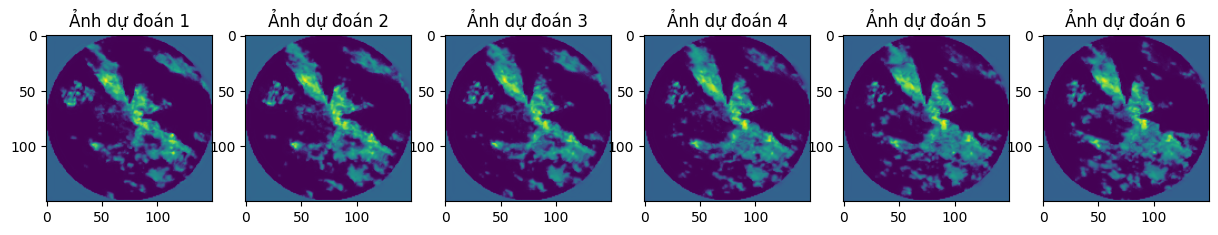

In [24]:
# Kết hợp ConvLSTM và Bi-ConvLSTM
best_seed_ConvLSTM_And_BiConvLSTM = train_model_FC(y_val, [val_pred_ConvLTSM, val_pred_BiConvLTSM])

# Đánh giá mô hình
combined_ConvLSTM_And_BiConvLSTM_pre = model_FC(best_seed_ConvLSTM_And_BiConvLSTM, [predicted_images_ConvLTSM, predicted_images_BiConvLTSM])
evaluate(y_test, combined_ConvLSTM_And_BiConvLSTM_pre)

# Vẽ các ảnh dự đoán
plots(combined_ConvLSTM_And_BiConvLSTM_pre)

1/1 [==============================] - 0s 99ms/step
Seed: 0, Score: 0.09901448329435818
1/1 [==============================] - 0s 102ms/step
Seed: 10, Score: 0.13331942994064178
1/1 [==============================] - 0s 100ms/step
Seed: 20, Score: 0.10549103329777987
1/1 [==============================] - 0s 101ms/step
Seed: 30, Score: 0.11953536148468002
1/1 [==============================] - 0s 102ms/step
Seed: 40, Score: 0.13975390551446146
1/1 [==============================] - 0s 99ms/step
Seed: 50, Score: 0.2038422409559424
1/1 [==============================] - 0s 101ms/step
Seed: 60, Score: 0.14290315971637427
1/1 [==============================] - 0s 102ms/step
Seed: 70, Score: 0.09587419044555061
1/1 [==============================] - 0s 102ms/step
Seed: 80, Score: 0.1469430089459923
1/1 [==============================] - 0s 101ms/step
Seed: 90, Score: 0.12484390474215397
1/1 [==============================] - 0s 122ms/step
Seed: 100, Score: 0.08802724459206342
1/1 [=========

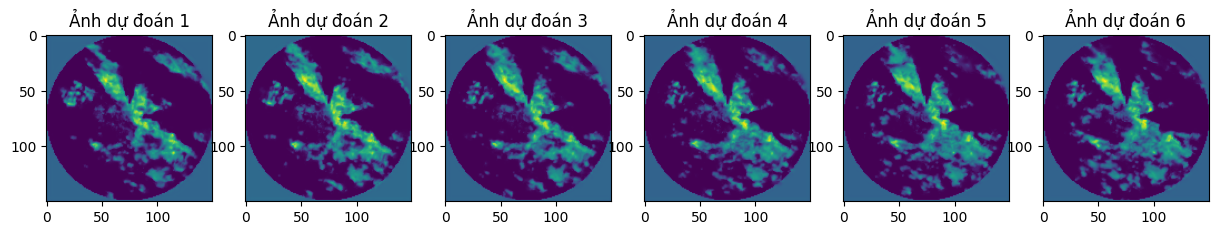

In [25]:
# Kết hợp ConvLSTM và ConvGRU
best_seed_ConvLSTM_And_ConvGRU = train_model_FC(y_val, [val_pred_ConvLTSM, val_pred_ConvGRU])

# Đánh giá mô hình
combined_ConvLSTM_And_ConvGRU_pre = model_FC(best_seed_ConvLSTM_And_ConvGRU, [predicted_images_ConvLTSM, predicted_images_ConvGRU])
evaluate(y_test, combined_ConvLSTM_And_ConvGRU_pre)

# Vẽ các ảnh dự đoán
plots(combined_ConvLSTM_And_ConvGRU_pre)

1/1 [==============================] - 0s 100ms/step
Seed: 0, Score: 0.09906985672793674
1/1 [==============================] - 0s 388ms/step
Seed: 10, Score: 0.13408442619435598
1/1 [==============================] - 0s 102ms/step
Seed: 20, Score: 0.10569775593540208
1/1 [==============================] - 0s 102ms/step
Seed: 30, Score: 0.11966459041265755
1/1 [==============================] - 0s 101ms/step
Seed: 40, Score: 0.14022244370018003
1/1 [==============================] - 0s 101ms/step
Seed: 50, Score: 0.2049568925440154
1/1 [==============================] - 0s 100ms/step
Seed: 60, Score: 0.1427931333406813
1/1 [==============================] - 0s 101ms/step
Seed: 70, Score: 0.09639902075661043
1/1 [==============================] - 0s 101ms/step
Seed: 80, Score: 0.1479498328707786
1/1 [==============================] - 0s 104ms/step
Seed: 90, Score: 0.1250567284778152
1/1 [==============================] - 0s 133ms/step
Seed: 100, Score: 0.08822493667843707
1/1 [=========

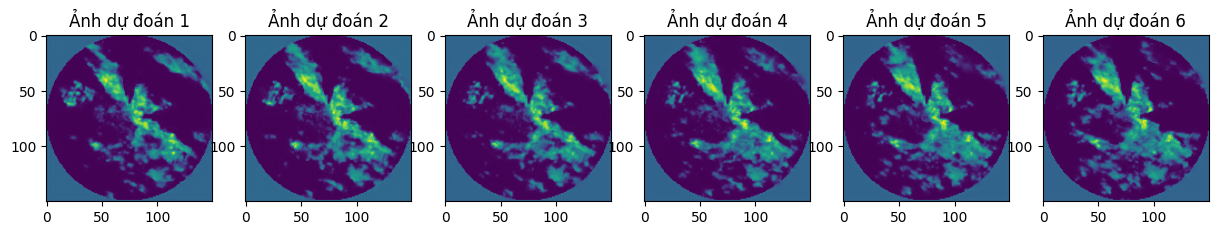

In [26]:
# Kết hợp BiConvLSTM và ConvGRU
best_seed_BiConvLSTM_And_ConvGRU = train_model_FC(y_val, [val_pred_BiConvLTSM, val_pred_ConvGRU])

# Đánh giá mô hình
combined_BiConvLSTM_And_ConvGRU_pre = model_FC(best_seed_BiConvLSTM_And_ConvGRU, [predicted_images_BiConvLTSM, predicted_images_ConvGRU])
evaluate(y_test, combined_BiConvLSTM_And_ConvGRU_pre)

# Vẽ các ảnh dự đoán
plots(combined_BiConvLSTM_And_ConvGRU_pre)

1/1 [==============================] - 0s 107ms/step
Seed: 0, Score: 0.11165706407879744
1/1 [==============================] - 0s 120ms/step
Seed: 10, Score: 0.1213690260410833
1/1 [==============================] - 0s 115ms/step
Seed: 20, Score: 0.10042466691116288
1/1 [==============================] - 0s 110ms/step
Seed: 30, Score: 0.12137838367045481
1/1 [==============================] - 0s 114ms/step
Seed: 40, Score: 0.17852419849757203
1/1 [==============================] - 0s 118ms/step
Seed: 50, Score: 0.19493769646685227
1/1 [==============================] - 0s 115ms/step
Seed: 60, Score: 0.16552099943364917
1/1 [==============================] - 0s 115ms/step
Seed: 70, Score: 0.08323914136310955
1/1 [==============================] - 0s 113ms/step
Seed: 80, Score: 0.13849592046035825
1/1 [==============================] - 0s 146ms/step
Seed: 90, Score: 0.08507388596278712
1/1 [==============================] - 0s 121ms/step
Seed: 100, Score: 0.1251694193661508
1/1 [=======

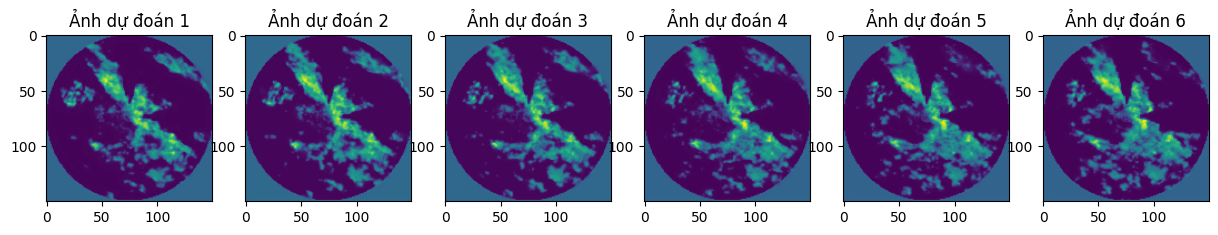

In [27]:
# Kết hợp ConvLSTM, BiConvLSTM và ConvGRU
best_seed_3_model = train_model_FC(y_val, [val_pred_ConvLTSM, val_pred_BiConvLTSM, val_pred_ConvGRU])

# Đánh giá mô hình
combined_3_model_pre = model_FC(best_seed_3_model, [predicted_images_ConvLTSM, predicted_images_BiConvLTSM, predicted_images_ConvGRU])
evaluate(y_test, combined_3_model_pre)

# Vẽ các ảnh dự đoán
plots(combined_3_model_pre)

### Sử dụng Linear Regression

In [28]:
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

X_train_val_gru = np.concatenate((X_train_gru, X_val_gru), axis=0)
y_train_val_gru = np.concatenate((y_train_gru, y_val_gru), axis=0)

# Tạo DataLoader cho training and validation
X_train_val_tensor = torch.tensor(X_train_val_gru, dtype=torch.float32)
y_train_val_tensor = torch.tensor(y_train_val_gru, dtype=torch.float32)
train_val_dataset = TensorDataset(X_train_val_tensor, y_train_val_tensor)
train_val_dataloader = DataLoader(train_val_dataset)

In [29]:
# Dự đoán trên mô hình ConvLSTM
pred_train_val_ConvLTSM = test_model(best_model_ConvLTSM, X_train_val)

# pred_test_ConvLTSM = test_model(best_model_ConvLTSM, X_test)

2/2 [==============================] - 25s 10s/step


In [30]:
# Dự đoán trên mô hình BiConvLSTM
pred_train_val_BiConvLTSM = test_model_BiConvLSTM(best_model_BiConvLTSM, X_train_val)

# pred_test_BiConvLTSM = test_model_BiConvLSTM(best_model_BiConvLTSM, X_test)

2/2 [==============================] - 148s 59s/step


In [31]:
# Dự đoán trên mô hình ConvGRU
pred_train_val_ConvGRU = test_model_ConvGRU(X_train_val_gru, best_model_path_ConvGRU, train_val_dataloader)

# pred_test_ConvGRU = test_model_ConvGRU(X_train_val_gru, best_model_path_ConvGRU, test_dataloader)

In [32]:
def model_learn(pred_train_val1, pred_train_val2, y_train_val, pred_test1, pred_test2):
    # Số lượng mẫu trong tập huấn luyện và kiểm tra
    shape_train = pred_train_val1.shape[0]
    shape_test = pred_test1.shape[0]

    # Biến đổi chuỗi ảnh thành dạng vector
    pre_img_ConvLTSM_train = pred_train_val1.reshape(shape_train, -1)
    pre_img_BiConvLTSM_train = pred_train_val2.reshape(shape_train, -1)
    img_pre_1 = pred_test1.reshape(shape_test, -1)
    img_pre_2 = pred_test2.reshape(shape_test, -1)

    # Kết hợp đầu ra từ hai mô hình
    X_train = np.hstack((pre_img_ConvLTSM_train, pre_img_BiConvLTSM_train))
    X_test = np.hstack((img_pre_1, img_pre_2))

    y_train = y_train_val.reshape(shape_train, -1)
    
    # Khởi tạo và huấn luyện mô hình hồi quy tuyến tính meta
    meta_model = LinearRegression()
    meta_model.fit(X_train, y_train)

    # Dự đoán với mô hình meta trên tập kiểm tra
    pred_learn = meta_model.predict(X_test)
    
    # Đảm bảo dự đoán cuối cùng có cùng kích thước như ảnh gốc
    target_shape = y_train_val.shape[1:]
    preds_img = pred_learn.reshape(shape_test, *target_shape)

    return preds_img

In [33]:
def plots_learn(predicted_images):
    fig, axs = plt.subplots(1, len(predicted_images), figsize=(15, 25))
    for i in range(len(predicted_images)):
        # Đảm bảo ảnh có kích thước đúng để hiển thị
        img = predicted_images[i].reshape(150, 150)  # Thay đổi kích thước này nếu cần
        axs[i].imshow(img)  # Hiển thị ảnh với thang màu xám
        axs[i].set_title(f"Ảnh dự đoán {i+1}")
        axs[i].axis('off')  # Tắt các trục để ảnh rõ ràng hơn
    plt.show()

Mean Squared Error (MSE): 0.018250194046675154
Mean Absolute Error (MAE): 0.06529495420650422
R-squared (R2) Score: 0.3876979363278904


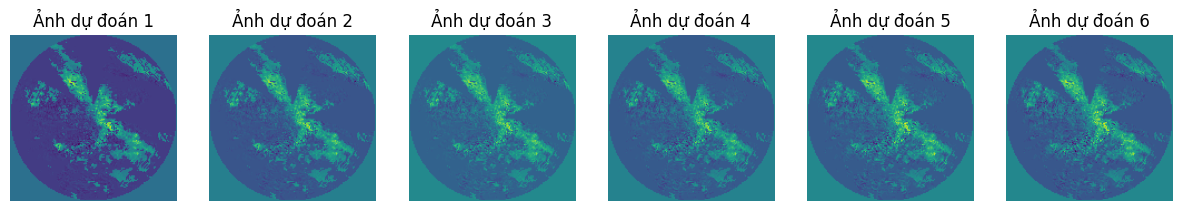

In [34]:
# Kết hợp ConvLSTM và BiConvLSTM
pred_img_ConvLSTM_And_BiConvLSTM = model_learn(pred_train_val_ConvLTSM, pred_train_val_BiConvLTSM, 
                                               y_train_val, 
                                               predicted_images_ConvLTSM, predicted_images_BiConvLTSM)

# Đánh giá mô hình
evaluate(y_test, pred_img_ConvLSTM_And_BiConvLSTM)

# Vẽ các ảnh dự đoán
plots_learn(pred_img_ConvLSTM_And_BiConvLSTM)

Mean Squared Error (MSE): 0.018105764539014683
Mean Absolute Error (MAE): 0.06508405390482698
R-squared (R2) Score: 0.39254361004344007


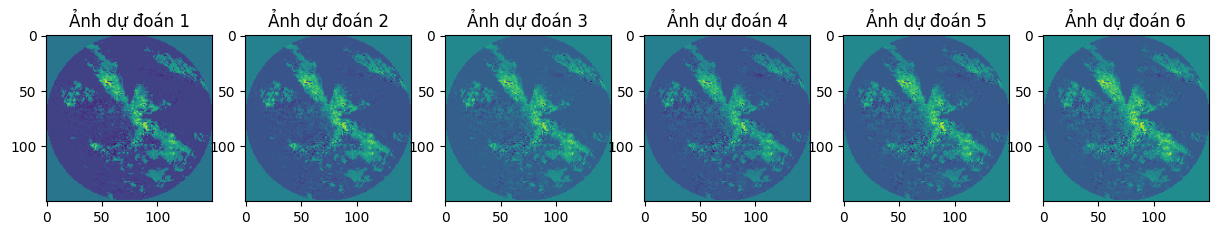

In [35]:
# Kết hợp ConvLSTM và ConvGRU
pred_img_ConvLSTM_And_ConvGRU = model_learn(pred_train_val_ConvLTSM, pred_train_val_ConvGRU, 
                                            y_train_val, 
                                            predicted_images_ConvLTSM, predicted_images_ConvGRU)

# Đánh giá mô hình
evaluate(y_test, pred_img_ConvLSTM_And_ConvGRU)

# Vẽ các ảnh dự đoán
plots(pred_img_ConvLSTM_And_ConvGRU)

Mean Squared Error (MSE): 0.01881215934561833
Mean Absolute Error (MAE): 0.06619042480201587
R-squared (R2) Score: 0.36884375256551505


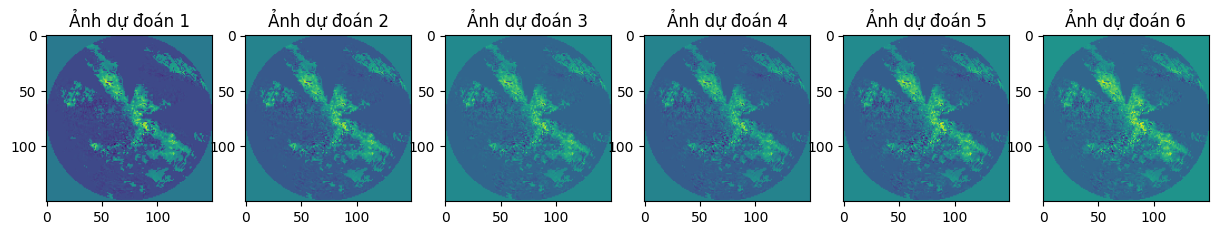

In [36]:
# Kết hợp BiConvLSTM và ConvGRU
pred_img_BiConvLSTM_And_ConvGRU = model_learn(pred_train_val_BiConvLTSM, pred_train_val_ConvGRU, 
                                              y_train_val, 
                                              predicted_images_BiConvLTSM, predicted_images_ConvGRU)

# Đánh giá mô hình
evaluate(y_test, pred_img_BiConvLSTM_And_ConvGRU)

# Vẽ các ảnh dự đoán
plots(pred_img_BiConvLSTM_And_ConvGRU)

Mean Squared Error (MSE): 0.01832243275707811
Mean Absolute Error (MAE): 0.06533326841168148
R-squared (R2) Score: 0.38527429571652927


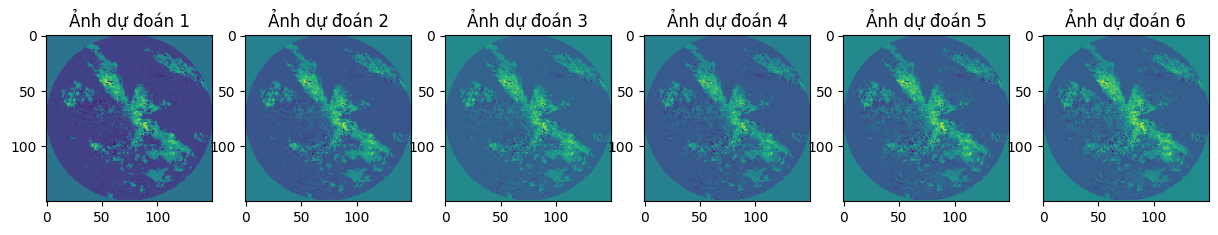

In [37]:
def model_learn_3_model(pred_train_val1, pred_train_val2, pred_train_val3, y_train_val, pred_test1, pred_test2, pred_test3):
    # Số lượng mẫu trong tập huấn luyện và kiểm tra
    shape_train = pred_train_val1.shape[0]
    shape_test = pred_test1.shape[0]

    # Biến đổi chuỗi ảnh thành dạng vector
    pre_img_ConvLTSM_train = pred_train_val1.reshape(shape_train, -1)
    pre_img_BiConvLTSM_train = pred_train_val2.reshape(shape_train, -1)
    pre_img_3_train = pred_train_val3.reshape(shape_train, -1)

    img_pre_1 = pred_test1.reshape(shape_test, -1)
    img_pre_2 = pred_test2.reshape(shape_test, -1)
    img_pre_3 = pred_test3.reshape(shape_test, -1)

    # Kết hợp đầu ra từ ba mô hình
    X_train = np.hstack((pre_img_ConvLTSM_train, pre_img_BiConvLTSM_train, pre_img_3_train))
    X_test = np.hstack((img_pre_1, img_pre_2, img_pre_3))

    y_train = y_train_val.reshape(shape_train, -1)
    
    # Khởi tạo và huấn luyện mô hình hồi quy tuyến tính meta
    meta_model = LinearRegression()
    meta_model.fit(X_train, y_train)

    # Dự đoán với mô hình meta trên tập kiểm tra
    pred_learn = meta_model.predict(X_test)
    
    # Đảm bảo dự đoán cuối cùng có cùng kích thước như ảnh gốc
    target_shape = y_train_val.shape[1:]
    preds_img = pred_learn.reshape(shape_test, *target_shape)

    return preds_img


# Kết hợp BiConvLSTM và ConvGRU
pred_img_3_model = model_learn_3_model(pred_train_val_ConvLTSM, pred_train_val_BiConvLTSM, pred_train_val_ConvGRU, 
                                       y_train_val, 
                                       predicted_images_ConvLTSM, predicted_images_BiConvLTSM, predicted_images_ConvGRU)

# Đánh giá mô hình
evaluate(y_test, pred_img_3_model)

# Vẽ các ảnh dự đoán
plots(pred_img_3_model)